In [1]:
# =============================================================================
# CELL 1: Import Libraries & Setup
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
from IPython.display import display, HTML

print("✓ Import thành công!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Import thành công!
NumPy version: 2.3.4
Pandas version: 2.3.3


In [2]:
# =============================================================================
# CELL 2: Define Base Class - Gaussian Naive Bayes
# =============================================================================
class MyGaussianNB_Base:
    """Base class cho Gaussian Naive Bayes"""
    
    def __init__(self, name="GNB"):
        self.name = name
        self.classes = None
        self.class_prior = {}
        self.mean = {}
        self.var = {}
        self.epsilon = 0
        self.train_time = 0
        self.pred_time = 0
        
    def _calculate_log_pdf_vectorized(self, X, mean, var):
        """Tính log-PDF của Gaussian (vectorized)"""
        const = -0.5 * np.log(2 * np.pi * var)
        dist = -0.5 * ((X - mean) ** 2) / var
        return const + dist
    
    def predict(self, X):
        """Dự đoán nhãn"""
        X = np.array(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_posteriors = np.zeros((n_samples, n_classes))
        
        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.class_prior[c])
            log_pdf = self._calculate_log_pdf_vectorized(X, self.mean[c], self.var[c])
            log_likelihood = np.sum(log_pdf, axis=1)
            log_posteriors[:, idx] = log_prior + log_likelihood
        
        return self.classes[np.argmax(log_posteriors, axis=1)]
    
    def score(self, X, y):
        """Tính accuracy"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

print("Base class định nghĩa xong!")

Base class định nghĩa xong!


In [3]:
# =============================================================================
# CELL 3: METHOD 1 - MLE (Maximum Likelihood Estimation)
# =============================================================================
class GaussianNB_MLE(MyGaussianNB_Base):
    """
    METHOD 1: Pure MLE (No Regularization)
    
    Công thức: σ² = σ²_MLE (không cộng thêm gì)
    Epsilon chỉ để tránh division by zero (≈ 0)
    """
    
    def __init__(self):
        super().__init__(name="MLE")
        
    def fit(self, X, y):
        t0 = time.time()
        
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Tính statistics
        var_per_feature = np.var(X, axis=0)
        max_var = np.max(var_per_feature)
        mean_var = np.mean(var_per_feature)
        
        # ═══════════════════════════════════════
        # MLE: Epsilon CỰC NHỎ (chỉ tránh /0)
        # ═══════════════════════════════════════
        self.epsilon = 1e-15
        
        print(f"\n{'='*70}")
        print(f"[METHOD 1: MLE - Pure Maximum Likelihood]")
        print(f"{'='*70}")
        print(f"  Formula:       σ² = σ²_MLE (no regularization)")
        print(f"  Epsilon:       {self.epsilon:.2e} (numerical safety only)")
        print(f"  Max variance:  {max_var:.2e}")
        print(f"  Mean variance: {mean_var:.2e}")
        print(f"{'='*70}\n")
        
        # Train từng class
        for c in self.classes:
            X_c = X[y == c]
            n_c = len(X_c)
            
            self.class_prior[c] = (n_c + 1) / (n_samples + len(self.classes))
            self.mean[c] = np.mean(X_c, axis=0)
            
            # Pure MLE variance
            var_mle = np.var(X_c, axis=0)
            self.var[c] = var_mle + self.epsilon
            
            print(f"  Class '{c}': N={n_c:>6,} | Avg Var={np.mean(var_mle):.3e}")
        
        self.train_time = time.time() - t0
        print(f"\n✓ Training done in {self.train_time:.2f}s\n")
        return self

print("MLE class định nghĩa xong!")

MLE class định nghĩa xong!


In [4]:
# =============================================================================
# CELL 4: METHOD 2 - MAP (Maximum A Posteriori)
# =============================================================================
class GaussianNB_MAP(MyGaussianNB_Base):
    """
    METHOD 2: MAP Estimation với Inverse-Gamma Prior
    
    Công thức (simplified): ε = mean_var / N
    Lý thuyết: σ²_MAP ≈ σ²_MLE + (2β - σ²_MLE(2α+2)) / N
    """
    
    def __init__(self, alpha=1.0, use_full_formula=False):
        super().__init__(name="MAP")
        self.alpha = alpha
        self.use_full_formula = use_full_formula
        
    def fit(self, X, y):
        t0 = time.time()
        
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Tính statistics
        var_per_feature = np.var(X, axis=0)
        max_var = np.max(var_per_feature)
        mean_var = np.mean(var_per_feature)
        
        # ═══════════════════════════════════════
        # MAP: Epsilon từ Bayesian Prior
        # ═══════════════════════════════════════
        if self.use_full_formula:
            # Full formula với correction term
            beta = mean_var
            epsilon_pos = 2 * beta / n_samples
            epsilon_neg = mean_var * (2*self.alpha + 2) / n_samples
            self.epsilon = epsilon_pos - epsilon_neg
            self.epsilon = max(self.epsilon, 1e-9 * max_var)
            formula = f"ε = (2β - σ²(2α+2)) / N"
        else:
            # Simplified formula (chỉ term dương)
            self.epsilon = mean_var / n_samples
            formula = f"ε = mean_var / N"
        
        # Safety net
        min_epsilon = 1e-15 * max_var
        if self.epsilon < min_epsilon:
            self.epsilon = min_epsilon
        
        print(f"\n{'='*70}")
        print(f"[METHOD 2: MAP - Bayesian Estimation]")
        print(f"{'='*70}")
        print(f"  Formula:       {formula}")
        print(f"  Prior:         InverseGamma(α={self.alpha})")
        print(f"  N samples:     {n_samples:,}")
        print(f"  Mean variance: {mean_var:.3e}")
        print(f"  Epsilon:       {self.epsilon:.3e}")
        print(f"  Ratio ε/max:   {self.epsilon/max_var:.3e}")
        print(f"{'='*70}\n")
        
        # Train từng class
        for c in self.classes:
            X_c = X[y == c]
            n_c = len(X_c)
            
            self.class_prior[c] = (n_c + 1) / (n_samples + len(self.classes))
            self.mean[c] = np.mean(X_c, axis=0)
            
            var_mle = np.var(X_c, axis=0)
            self.var[c] = var_mle + self.epsilon
            
            print(f"  Class '{c}': N={n_c:>6,} | "
                  f"Var(MLE)={np.mean(var_mle):.3e} | "
                  f"Var(MAP)={np.mean(self.var[c]):.3e}")
        
        self.train_time = time.time() - t0
        print(f"\n✓ Training done in {self.train_time:.2f}s\n")
        return self

print("MAP class định nghĩa xong!")

MAP class định nghĩa xong!


In [5]:
# =============================================================================
# CELL 5: METHOD 3 - Sklearn Style (Fixed Smoothing)
# =============================================================================
class GaussianNB_Sklearn(MyGaussianNB_Base):
    """
    METHOD 3: Sklearn-style Fixed Smoothing
    
    Công thức: ε = var_smoothing × max(variance)
    Default: var_smoothing = 1e-9
    """
    
    def __init__(self, var_smoothing=1e-9):
        super().__init__(name="Sklearn")
        self.var_smoothing = var_smoothing
        
    def fit(self, X, y):
        t0 = time.time()
        
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Tính statistics
        var_per_feature = np.var(X, axis=0)
        max_var = np.max(var_per_feature)
        mean_var = np.mean(var_per_feature)
        
        # ═══════════════════════════════════════
        # SKLEARN: Fixed ratio smoothing
        # ═══════════════════════════════════════
        self.epsilon = self.var_smoothing * max_var
        
        print(f"\n{'='*70}")
        print(f"[METHOD 3: Sklearn - Fixed Smoothing]")
        print(f"{'='*70}")
        print(f"  Formula:       ε = var_smoothing × max(var)")
        print(f"  var_smoothing: {self.var_smoothing:.2e}")
        print(f"  Max variance:  {max_var:.3e}")
        print(f"  Epsilon:       {self.epsilon:.3e}")
        print(f"  (Independent of N)")
        print(f"{'='*70}\n")
        
        # Train từng class
        for c in self.classes:
            X_c = X[y == c]
            n_c = len(X_c)
            
            self.class_prior[c] = (n_c + 1) / (n_samples + len(self.classes))
            self.mean[c] = np.mean(X_c, axis=0)
            
            var_mle = np.var(X_c, axis=0)
            self.var[c] = var_mle + self.epsilon
            
            print(f"  Class '{c}': N={n_c:>6,} | "
                  f"Var(MLE)={np.mean(var_mle):.3e} | "
                  f"Var(Final)={np.mean(self.var[c]):.3e}")
        
        self.train_time = time.time() - t0
        print(f"\n✓ Training done in {self.train_time:.2f}s\n")
        return self

print("Sklearn class định nghĩa xong!")


Sklearn class định nghĩa xong!


In [6]:
# =============================================================================
# CELL 6: Helper Functions - Load Data
# =============================================================================
def load_data_trusted(file_path):
    """Load dữ liệu với cache"""
    base_dir = os.path.dirname(file_path)
    filename = os.path.basename(file_path).replace('.csv', '.pkl')
    cache_path = os.path.join(base_dir, filename)
    
    # Kiểm tra cache
    if os.path.exists(cache_path):
        print(f"[FAST LOAD] Đang load từ cache: {cache_path}")
        start = time.time()
        with open(cache_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✓ Load xong trong {time.time() - start:.2f}s!")
        return data['X'], data['y']
    
    # Đọc CSV lần đầu
    print(f"[SLOW LOAD] Đang đọc CSV: {file_path}")
    start = time.time()
    
    df = pd.read_csv(file_path, engine="python", on_bad_lines="skip")
    df.columns = df.columns.str.strip()
    
    # Tách label
    label_col = 'Label' if 'Label' in df.columns else df.columns[-1]
    df.dropna(subset=[label_col], inplace=True)
    y = df[label_col].values
    
    # Xử lý features
    X_raw = df.drop(columns=[label_col])
    X_num = X_raw.select_dtypes(include=[np.number])
    X_num = X_num.replace([np.inf, -np.inf], np.nan).fillna(0).clip(lower=0)
    X = X_num.values.astype(np.float32)
    
    # Transform
    print("-> Log Transform & Standard Scaling...")
    X = np.log1p(X)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1.0
    X = (X - mean) / std
    
    print(f"✓ Xử lý xong trong {(time.time() - start)/60:.2f} phút")
    
    # Lưu cache
    print(f"[CACHE] Đang lưu cache...")
    with open(cache_path, 'wb') as f:
        pickle.dump({'X': X, 'y': y}, f, protocol=4)
    print("✓ Cache đã lưu!")
    
    return X, y

print("Helper functions định nghĩa xong!")

Helper functions định nghĩa xong!


In [7]:
# =============================================================================
# CELL 7: Load Dataset (UPDATED PATHS)
# =============================================================================
import os
import numpy as np

# Cấu hình đường dẫn: Từ notebooks (..) ra ngoài -> vào data -> processed
FILE_PATH = os.path.abspath(os.path.join("..", "data", "processed", "MASTER_DATASET_FINAL_ALL_V4.csv"))

print("="*70)
print(f"LOADING DATASET FROM: {FILE_PATH}")
print("="*70)

try:
    # Kiểm tra file có tồn tại không trước khi load
    if not os.path.exists(FILE_PATH):
        raise FileNotFoundError(f"Không tìm thấy file tại: {FILE_PATH}")

    X, y = load_data_trusted(FILE_PATH)
    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Shape: {X.shape}")
    print(f"  Samples: {X.shape[0]:,}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Classes: {len(np.unique(y))}")
    print(f"  Class distribution:")
    
    unique, counts = np.unique(y, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"    {cls}: {cnt:,} ({cnt/len(y)*100:.2f}%)")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # raise # Comment lại để không crash notebook nếu muốn debug tiếp

LOADING DATASET FROM: D:\lessonsatuniversity\DoAn\Prj1\IT 3150\data\processed\MASTER_DATASET_FINAL_ALL_V4.csv
[SLOW LOAD] Đang đọc CSV: D:\lessonsatuniversity\DoAn\Prj1\IT 3150\data\processed\MASTER_DATASET_FINAL_ALL_V4.csv
-> Log Transform & Standard Scaling...
✓ Xử lý xong trong 71.22 phút
[CACHE] Đang lưu cache...
✓ Cache đã lưu!

✓ Dataset loaded successfully!
  Shape: (4301121, 78)
  Samples: 4,301,121
  Features: 78
  Classes: 8
  Class distribution:
    Benign: 1,669,437 (38.81%)
    Bot: 288,403 (6.71%)
    BruteForce: 208,036 (4.84%)
    DDoS: 815,769 (18.97%)
    DoS: 911,439 (21.19%)
    Infiltration: 169,156 (3.93%)
    PortScan: 176,050 (4.09%)
    Web Attack: 62,831 (1.46%)


In [8]:
# =============================================================================
# CELL 8: Split Train/Test & Scale (Fix Data Leakage)
# =============================================================================
from sklearn.model_selection import train_test_split

print("\n" + "="*70)
print("SPLITTING & SCALING DATA")
print("="*70)

# 1. Chia Train/Test với Stratify (Giữ nguyên tỷ lệ các lớp)
# Lưu ý: X ở đây phải là dữ liệu thô (chưa scale), chỉ mới log transform (nếu có) từ Cell 6
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)

print(f"Split xong với stratify=y (Giữ tỷ lệ class cân bằng).")

# 2. Tính Mean và Std CHỈ trên tập Train (Tránh Data Leakage)
print("Đang tính Mean/Std trên tập Train...")
mean_train = np.mean(X_train_raw, axis=0)
std_train = np.std(X_train_raw, axis=0)

# Xử lý trường hợp độ lệch chuẩn = 0 (để tránh chia cho 0)
std_train[std_train == 0] = 1e-15 

# 3. Áp dụng chuẩn hóa (Standard Scaling)
X_train = (X_train_raw - mean_train) / std_train
# Quan trọng: Tập Test phải được scale bằng tham số của tập Train
X_test = (X_test_raw - mean_train) / std_train 

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set:  {X_test.shape[0]:,} samples")
print(f"Split ratio: 80/20")
print("Đã xử lý Data Leakage thành công.")


SPLITTING & SCALING DATA
Split xong với stratify=y (Giữ tỷ lệ class cân bằng).
Đang tính Mean/Std trên tập Train...
Train set: 3,440,896 samples
Test set:  860,225 samples
Split ratio: 80/20
Đã xử lý Data Leakage thành công.


In [9]:
# =============================================================================
# CELL 9: Train Method 1 - MLE
# =============================================================================
print("\n" + "█"*70)
print("TRAINING METHOD 1: MLE")
print("█"*70)

model_mle = GaussianNB_MLE()
model_mle.fit(X_train, y_train)

# Predict
print("[INFO] Predicting...")
t0 = time.time()
y_pred_mle = model_mle.predict(X_test)
model_mle.pred_time = time.time() - t0

acc_mle = model_mle.score(X_test, y_test)
print(f"✓ Accuracy: {acc_mle:.4f}")
print(f"✓ Prediction time: {model_mle.pred_time:.2f}s")


██████████████████████████████████████████████████████████████████████
TRAINING METHOD 1: MLE
██████████████████████████████████████████████████████████████████████

[METHOD 1: MLE - Pure Maximum Likelihood]
  Formula:       σ² = σ²_MLE (no regularization)
  Epsilon:       1.00e-15 (numerical safety only)
  Max variance:  1.02e+00
  Mean variance: 9.32e-01

  Class 'Benign': N=1,335,549 | Avg Var=1.086e+00
  Class 'Bot': N=230,722 | Avg Var=4.228e-01
  Class 'BruteForce': N=166,429 | Avg Var=1.353e-01
  Class 'DDoS': N=652,615 | Avg Var=5.497e-01
  Class 'DoS': N=729,151 | Avg Var=7.756e-01
  Class 'Infiltration': N=135,325 | Avg Var=1.594e+00
  Class 'PortScan': N=140,840 | Avg Var=1.682e-01
  Class 'Web Attack': N=50,265 | Avg Var=8.630e-01

✓ Training done in 7.92s

[INFO] Predicting...
✓ Accuracy: 0.7564
✓ Prediction time: 5.72s


In [10]:
# =============================================================================
# CELL 10: Train Method 2 - MAP
# =============================================================================
print("\n" + "█"*70)
print("TRAINING METHOD 2: MAP")
print("█"*70)

model_map = GaussianNB_MAP(alpha=1.0, use_full_formula=False)
model_map.fit(X_train, y_train)

# Predict
print("[INFO] Predicting...")
t0 = time.time()
y_pred_map = model_map.predict(X_test)
model_map.pred_time = time.time() - t0

acc_map = model_map.score(X_test, y_test)
print(f"✓ Accuracy: {acc_map:.4f}")
print(f"✓ Prediction time: {model_map.pred_time:.2f}s")


██████████████████████████████████████████████████████████████████████
TRAINING METHOD 2: MAP
██████████████████████████████████████████████████████████████████████

[METHOD 2: MAP - Bayesian Estimation]
  Formula:       ε = mean_var / N
  Prior:         InverseGamma(α=1.0)
  N samples:     3,440,896
  Mean variance: 9.320e-01
  Epsilon:       2.709e-07
  Ratio ε/max:   2.650e-07

  Class 'Benign': N=1,335,549 | Var(MLE)=1.086e+00 | Var(MAP)=1.086e+00
  Class 'Bot': N=230,722 | Var(MLE)=4.228e-01 | Var(MAP)=4.228e-01
  Class 'BruteForce': N=166,429 | Var(MLE)=1.353e-01 | Var(MAP)=1.353e-01
  Class 'DDoS': N=652,615 | Var(MLE)=5.497e-01 | Var(MAP)=5.497e-01
  Class 'DoS': N=729,151 | Var(MLE)=7.756e-01 | Var(MAP)=7.756e-01
  Class 'Infiltration': N=135,325 | Var(MLE)=1.594e+00 | Var(MAP)=1.594e+00
  Class 'PortScan': N=140,840 | Var(MLE)=1.682e-01 | Var(MAP)=1.682e-01
  Class 'Web Attack': N=50,265 | Var(MLE)=8.630e-01 | Var(MAP)=8.630e-01

✓ Training done in 6.79s

[INFO] Predicting..

In [11]:
# =============================================================================
# CELL 11: Train Method 3 - Sklearn
# =============================================================================
print("\n" + "█"*70)
print("TRAINING METHOD 3: SKLEARN")
print("█"*70)

model_sklearn = GaussianNB_Sklearn(var_smoothing=1e-9)
model_sklearn.fit(X_train, y_train)

# Predict
print("[INFO] Predicting...")
t0 = time.time()
y_pred_sklearn = model_sklearn.predict(X_test)
model_sklearn.pred_time = time.time() - t0

acc_sklearn = model_sklearn.score(X_test, y_test)
print(f"✓ Accuracy: {acc_sklearn:.4f}")
print(f"✓ Prediction time: {model_sklearn.pred_time:.2f}s")



██████████████████████████████████████████████████████████████████████
TRAINING METHOD 3: SKLEARN
██████████████████████████████████████████████████████████████████████

[METHOD 3: Sklearn - Fixed Smoothing]
  Formula:       ε = var_smoothing × max(var)
  var_smoothing: 1.00e-09
  Max variance:  1.022e+00
  Epsilon:       1.022e-09
  (Independent of N)

  Class 'Benign': N=1,335,549 | Var(MLE)=1.086e+00 | Var(Final)=1.086e+00
  Class 'Bot': N=230,722 | Var(MLE)=4.228e-01 | Var(Final)=4.228e-01
  Class 'BruteForce': N=166,429 | Var(MLE)=1.353e-01 | Var(Final)=1.353e-01
  Class 'DDoS': N=652,615 | Var(MLE)=5.497e-01 | Var(Final)=5.497e-01
  Class 'DoS': N=729,151 | Var(MLE)=7.756e-01 | Var(Final)=7.756e-01
  Class 'Infiltration': N=135,325 | Var(MLE)=1.594e+00 | Var(Final)=1.594e+00
  Class 'PortScan': N=140,840 | Var(MLE)=1.682e-01 | Var(Final)=1.682e-01
  Class 'Web Attack': N=50,265 | Var(MLE)=8.630e-01 | Var(Final)=8.630e-01

✓ Training done in 6.70s

[INFO] Predicting...
✓ Accuracy

In [12]:
# =============================================================================
# CELL 12: Compare Results - Summary Table
# =============================================================================
print("\n" + "="*90)
print("COMPARISON SUMMARY")
print("="*90)

results = {
    'Method': ['MLE', 'MAP', 'Sklearn'],
    'Accuracy': [acc_mle, acc_map, acc_sklearn],
    'Train Time (s)': [model_mle.train_time, model_map.train_time, model_sklearn.train_time],
    'Pred Time (s)': [model_mle.pred_time, model_map.pred_time, model_sklearn.pred_time],
    'Epsilon': [model_mle.epsilon, model_map.epsilon, model_sklearn.epsilon]
}

df_results = pd.DataFrame(results)
df_results['Accuracy (%)'] = df_results['Accuracy'] * 100

# Thêm ranking
df_results['Rank'] = df_results['Accuracy'].rank(ascending=False).astype(int)
df_results = df_results.sort_values('Rank')

print(df_results.to_string(index=False))

# Tìm best
best_method = df_results.iloc[0]['Method']
best_acc = df_results.iloc[0]['Accuracy']

print("\n" + "="*90)
print(f"🏆 BEST METHOD: {best_method} (Accuracy: {best_acc:.4f})")
print("="*90)

# So sánh chi tiết
print("\nPairwise Comparison:")
print(f"  MAP vs MLE:     {(acc_map - acc_mle)*100:+.3f}% {'✓' if acc_map > acc_mle else '✗'}")
print(f"  MAP vs Sklearn: {(acc_map - acc_sklearn)*100:+.3f}% {'✓' if acc_map > acc_sklearn else '✗'}")
print(f"  Sklearn vs MLE: {(acc_sklearn - acc_mle)*100:+.3f}% {'✓' if acc_sklearn > acc_mle else '✗'}")

print("\nEpsilon Comparison:")
print(f"  MLE:     {model_mle.epsilon:.2e}")
print(f"  MAP:     {model_map.epsilon:.2e} ({model_map.epsilon/model_mle.epsilon:.1e}× MLE)")
print(f"  Sklearn: {model_sklearn.epsilon:.2e} ({model_sklearn.epsilon/model_mle.epsilon:.1e}× MLE)")



COMPARISON SUMMARY
 Method  Accuracy  Train Time (s)  Pred Time (s)      Epsilon  Accuracy (%)  Rank
    MAP  0.768720        6.788766       5.674916 2.708582e-07     76.871981     1
Sklearn  0.767507        6.700633       5.562679 1.022000e-09     76.750734     2
    MLE  0.756386        7.920141       5.724593 1.000000e-15     75.638583     3

🏆 BEST METHOD: MAP (Accuracy: 0.7687)

Pairwise Comparison:
  MAP vs MLE:     +1.233% ✓
  MAP vs Sklearn: +0.121% ✓
  Sklearn vs MLE: +1.112% ✓

Epsilon Comparison:
  MLE:     1.00e-15
  MAP:     2.71e-07 (2.7e+08× MLE)
  Sklearn: 1.02e-09 (1.0e+06× MLE)


In [13]:
# =============================================================================
# CELL 13: Detailed Metrics per Class
# =============================================================================
def calculate_metrics(y_true, y_pred):
    """Tính precision, recall, f1 cho từng class"""
    labels = np.unique(y_true)
    metrics = []
    
    # Confusion matrix
    label_to_idx = {label: i for i, label in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        cm[label_to_idx[true], label_to_idx[pred]] += 1
    
    # Calculate metrics per class
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        support = cm[i, :].sum()
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics.append({
            'Class': label,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })
    
    return pd.DataFrame(metrics), cm

# Tính metrics cho cả 3 methods
print("\n" + "="*90)
print("DETAILED METRICS - MLE")
print("="*90)
metrics_mle, cm_mle = calculate_metrics(y_test, y_pred_mle)
print(metrics_mle.to_string(index=False))
print(f"\nMacro Avg F1: {metrics_mle['F1-Score'].mean():.4f}")

print("\n" + "="*90)
print("DETAILED METRICS - MAP")
print("="*90)
metrics_map, cm_map = calculate_metrics(y_test, y_pred_map)
print(metrics_map.to_string(index=False))
print(f"\nMacro Avg F1: {metrics_map['F1-Score'].mean():.4f}")

print("\n" + "="*90)
print("DETAILED METRICS - SKLEARN")
print("="*90)
metrics_sklearn, cm_sklearn = calculate_metrics(y_test, y_pred_sklearn)
print(metrics_sklearn.to_string(index=False))
print(f"\nMacro Avg F1: {metrics_sklearn['F1-Score'].mean():.4f}")



DETAILED METRICS - MLE
       Class  Precision   Recall  F1-Score  Support
      Benign   0.941794 0.595870  0.729922   333888
         Bot   0.973228 0.990725  0.981898    57681
  BruteForce   0.578826 0.944649  0.717816    41607
        DDoS   0.932845 0.969238  0.950693   163154
         DoS   0.798562 0.782301  0.790348   182288
Infiltration   0.828857 0.335698  0.477857    33831
    PortScan   0.280949 0.899460  0.428161    35210
  Web Attack   0.240258 0.914531  0.380542    12566

Macro Avg F1: 0.6822

DETAILED METRICS - MAP
       Class  Precision   Recall  F1-Score  Support
      Benign   0.937573 0.605946  0.736134   333888
         Bot   0.971387 0.990569  0.980884    57681
  BruteForce   0.580106 0.944577  0.718778    41607
        DDoS   0.932625 0.969238  0.950579   163154
         DoS   0.804053 0.817498  0.810720   182288
Infiltration   0.762761 0.381189  0.508337    33831
    PortScan   0.313978 0.898239  0.465308    35210
  Web Attack   0.239059 0.862486  0.374357    

✓ Đã lưu: comparison_bar_charts.png


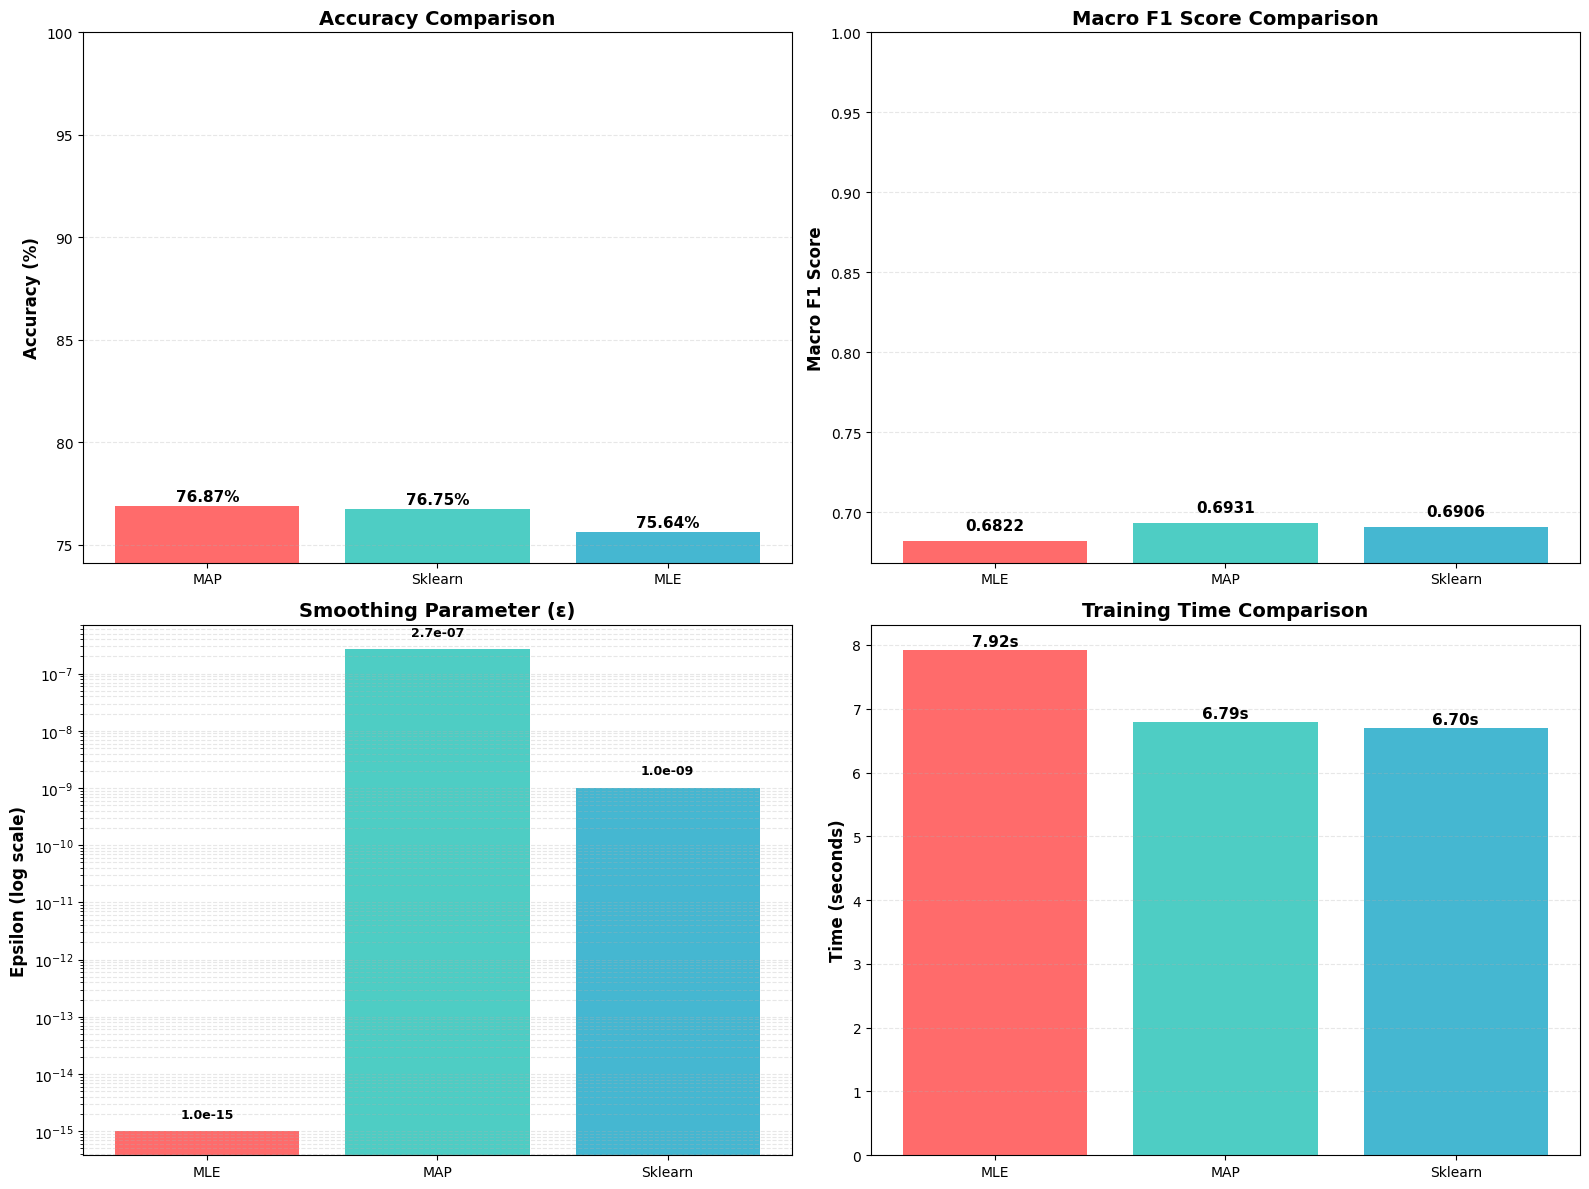

In [14]:
# =============================================================================
# CELL 14: Visualization - Bar Charts
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax = axes[0, 0]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = ax.bar(df_results['Method'], df_results['Accuracy (%)'], color=colors)
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([df_results['Accuracy (%)'].min() * 0.98, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. F1 Score comparison
ax = axes[0, 1]
f1_scores = [metrics_mle['F1-Score'].mean(), 
             metrics_map['F1-Score'].mean(), 
             metrics_sklearn['F1-Score'].mean()]
bars = ax.bar(['MLE', 'MAP', 'Sklearn'], f1_scores, color=colors)
ax.set_ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Macro F1 Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([min(f1_scores) * 0.98, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Epsilon comparison (log scale)
ax = axes[1, 0]
epsilons = [model_mle.epsilon, model_map.epsilon, model_sklearn.epsilon]
bars = ax.bar(['MLE', 'MAP', 'Sklearn'], epsilons, color=colors)
ax.set_ylabel('Epsilon (log scale)', fontsize=12, fontweight='bold')
ax.set_title('Smoothing Parameter (ε)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3, linestyle='--', which='both')

for bar, eps in zip(bars, epsilons):
    ax.text(bar.get_x() + bar.get_width()/2., eps * 1.5,
            f'{eps:.1e}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Training time
ax = axes[1, 1]
train_times = [model_mle.train_time, model_map.train_time, model_sklearn.train_time]
bars = ax.bar(['MLE', 'MAP', 'Sklearn'], train_times, color=colors)
ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('comparison_bar_charts.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: comparison_bar_charts.png")
plt.show()


✓ Đã lưu: confusion_matrices.png


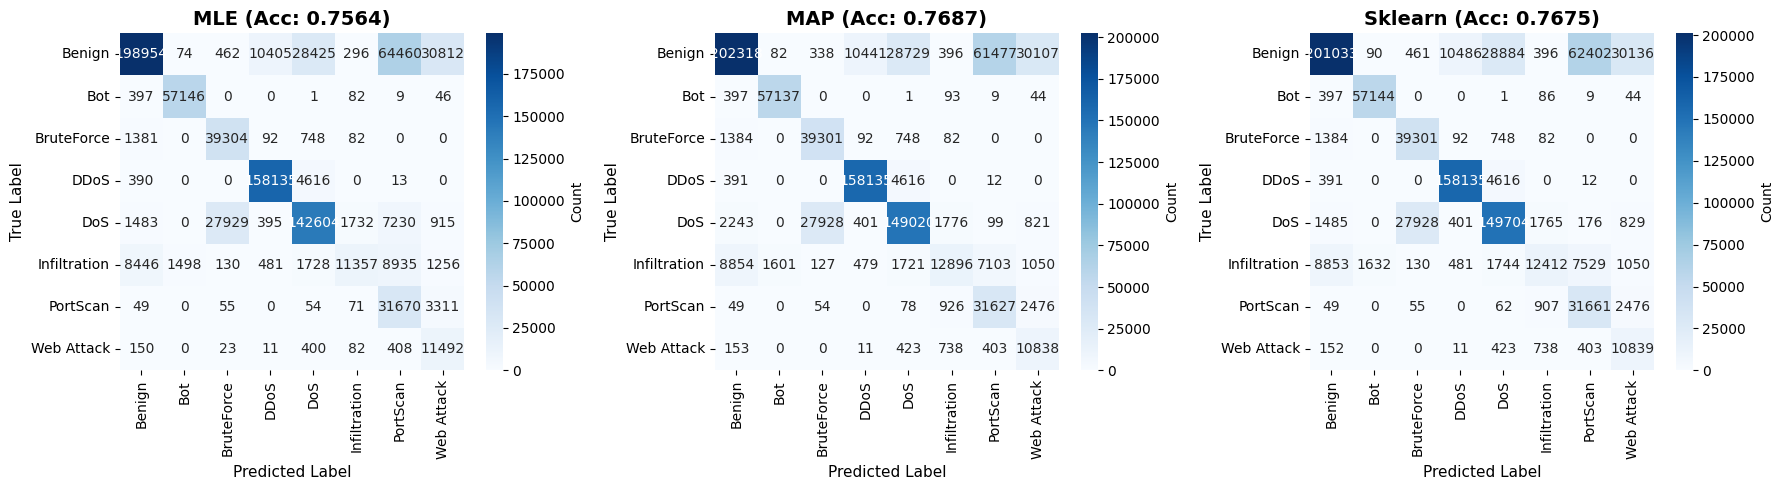

In [15]:
# =============================================================================
# CELL 15: Visualization - Confusion Matrices
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

labels = np.unique(y_test)
cms = [cm_mle, cm_map, cm_sklearn]
titles = ['MLE', 'MAP', 'Sklearn']
accs = [acc_mle, acc_map, acc_sklearn]

for ax, cm, title, acc in zip(axes, cms, titles, accs):
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{title} (Acc: {acc:.4f})', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: confusion_matrices.png")
plt.show()

In [16]:
# =============================================================================
# CELL MỚI: SO SÁNH CÔNG BẰNG BẰNG CROSS-VALIDATION (5-FOLD)
# =============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Cấu hình
K_FOLDS = 5
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Lưu kết quả
results = {
    'MLE': {'acc': [], 'f1': []},
    'MAP': {'acc': [], 'f1': []},
    'Sklearn': {'acc': [], 'f1': []}
}

print(f"\n" + "="*80)
print(f"BẮT ĐẦU CHẠY {K_FOLDS}-FOLD CROSS-VALIDATION")
print("="*80)

fold = 1
# X_full và y_full là toàn bộ dữ liệu (đã log transform ở Cell 6, nhưng CHƯA scale)
X_full = X  
y_full = y

for train_index, test_index in skf.split(X_full, y_full):
    print(f"\n--- Fold {fold}/{K_FOLDS} ---")
    
    # 1. Chia dữ liệu theo Fold
    X_train_fold, X_test_fold = X_full[train_index], X_full[test_index]
    y_train_fold, y_test_fold = y_full[train_index], y_full[test_index]
    
    # 2. CHUẨN HÓA (Quan trọng: Fit trên Train Fold, Transform lên Test Fold)
    mean_fold = np.mean(X_train_fold, axis=0)
    std_fold = np.std(X_train_fold, axis=0)
    std_fold[std_fold == 0] = 1e-15 # Tránh chia 0
    
    X_train_scaled = (X_train_fold - mean_fold) / std_fold
    X_test_scaled = (X_test_fold - mean_fold) / std_fold
    
    # ---------------------------------------------------------
    # 3. Chạy từng thuật toán
    # ---------------------------------------------------------
    
    # --- A. MLE ---
    mle_model = GaussianNB_MLE()
    mle_model.fit(X_train_scaled, y_train_fold)
    y_pred_mle = mle_model.predict(X_test_scaled)
    results['MLE']['acc'].append(accuracy_score(y_test_fold, y_pred_mle))
    results['MLE']['f1'].append(f1_score(y_test_fold, y_pred_mle, average='macro'))
    
    # --- B. MAP ---
    map_model = GaussianNB_MAP()
    map_model.fit(X_train_scaled, y_train_fold)
    y_pred_map = map_model.predict(X_test_scaled)
    results['MAP']['acc'].append(accuracy_score(y_test_fold, y_pred_map))
    results['MAP']['f1'].append(f1_score(y_test_fold, y_pred_map, average='macro'))
    
    # --- C. Sklearn ---
    # Lưu ý: Sklearn tính toán epsilon dựa trên X_train_scaled của mỗi fold
    skl_model = GaussianNB_Sklearn(var_smoothing=1e-9) 
    skl_model.fit(X_train_scaled, y_train_fold)
    y_pred_skl = skl_model.predict(X_test_scaled)
    results['Sklearn']['acc'].append(accuracy_score(y_test_fold, y_pred_skl))
    results['Sklearn']['f1'].append(f1_score(y_test_fold, y_pred_skl, average='macro'))
    
    print(f"Fold {fold} Done. MAP Acc: {results['MAP']['acc'][-1]:.4f}. MLE Acc: {results['MLE']['acc'][-1]:.4f}. Sklearn Acc: {results['Sklearn']['acc'][-1]:.4f}")
    print(f"Fold {fold} Done. MAP Macro: {results['MAP']['f1'][-1]:.4f}. MLE Macro: {results['MLE']['f1'][-1]:.4f}. Sklearn Macro: {results['Sklearn']['f1'][-1]:.4f}")
    fold += 1

# =============================================================================
# TỔNG HỢP KẾT QUẢ
# =============================================================================
print(f"\n" + "="*80)
print(f"KẾT QUẢ CUỐI CÙNG SAU {K_FOLDS} LẦN CHẠY")
print("="*80)

summary = []
for name in ['MLE', 'MAP', 'Sklearn']:
    avg_acc = np.mean(results[name]['acc'])
    std_acc = np.std(results[name]['acc'])
    avg_f1 = np.mean(results[name]['f1'])
    
    summary.append({
        'Method': name,
        'Avg Accuracy': f"{avg_acc:.4f} (±{std_acc:.4f})",
        'Avg Macro F1': f"{avg_f1:.4f}"
    })

df_summary = pd.DataFrame(summary)
print(df_summary)


BẮT ĐẦU CHẠY 5-FOLD CROSS-VALIDATION

--- Fold 1/5 ---

[METHOD 1: MLE - Pure Maximum Likelihood]
  Formula:       σ² = σ²_MLE (no regularization)
  Epsilon:       1.00e-15 (numerical safety only)
  Max variance:  1.04e+00
  Mean variance: 9.29e-01

  Class 'Benign': N=1,335,549 | Avg Var=1.084e+00
  Class 'Bot': N=230,723 | Avg Var=4.209e-01
  Class 'BruteForce': N=166,428 | Avg Var=1.357e-01
  Class 'DDoS': N=652,615 | Avg Var=5.491e-01
  Class 'DoS': N=729,152 | Avg Var=7.725e-01
  Class 'Infiltration': N=135,325 | Avg Var=1.589e+00
  Class 'PortScan': N=140,840 | Avg Var=1.675e-01
  Class 'Web Attack': N=50,264 | Avg Var=8.552e-01

✓ Training done in 6.70s


[METHOD 2: MAP - Bayesian Estimation]
  Formula:       ε = mean_var / N
  Prior:         InverseGamma(α=1.0)
  N samples:     3,440,896
  Mean variance: 9.294e-01
  Epsilon:       2.701e-07
  Ratio ε/max:   2.607e-07

  Class 'Benign': N=1,335,549 | Var(MLE)=1.084e+00 | Var(MAP)=1.084e+00
  Class 'Bot': N=230,723 | Var(MLE)=4.

In [20]:
# =============================================================================
# FINAL BATTLE: SO SÁNH 3 THUẬT TOÁN TRÊN FILE TEST RỜI
# =============================================================================
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report

print("\n" + "="*80)
print("SO SÁNH TRỰC DIỆN: MLE vs MAP vs SKLEARN (Trên File Test Rời)")
print("="*80)

# --- 1. CẤU HÌNH ĐƯỜNG DẪN MỚI ---
DATA_DIR = os.path.abspath(os.path.join("..", "data", "processed",))

TRAIN_FILE = os.path.join(DATA_DIR, "MASTER_DATASET_FINAL_ALL_V4.csv")
TEST_FILE  = os.path.join(DATA_DIR, "Cross_Validate", "File16_Final_79cols.csv")

# Kiểm tra file
print(f"Checking files...")
print(f" - Train: {TRAIN_FILE} [{'✅ FOUND' if os.path.exists(TRAIN_FILE) else '❌ MISSING'}]")
print(f" - Test : {TEST_FILE}  [{'✅ FOUND' if os.path.exists(TEST_FILE) else '❌ MISSING'}]")

# --- 2. HÀM XỬ LÝ AN TOÀN ---
def clean_and_transform(df):
    if 'Label' in df.columns:
        X = df.drop(columns=['Label'])
        y = df['Label']
    else:
        X = df
        y = None
    
    # Xử lý vô cực/NaN/Số âm
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X = X.clip(lower=0) 
    # Log Transform
    X_log = np.log1p(X.values.astype(np.float32))
    return X_log, y

# --- 3. HUẤN LUYỆN LẠI (ĐỂ ĐẢM BẢO CÓ ĐỦ 3 MODEL) ---
print(f"\n[1] Đang huấn luyện lại cả 3 model...")
if os.path.exists(TRAIN_FILE):
    df_train = pd.read_csv(TRAIN_FILE)
    X_train_log, y_train = clean_and_transform(df_train)
    
    # Tính Mean/Std
    mean_train = np.mean(X_train_log, axis=0)
    std_train = np.std(X_train_log, axis=0)
    std_train[std_train == 0] = 1e-15
    
    # Scale
    X_train_scaled = (X_train_log - mean_train) / std_train
    
    # Khai báo & Train 3 ông
    # Lưu ý: Đảm bảo bạn đã định nghĩa class GaussianNB_MLE, MAP... ở các cell trên
    # 1. MLE
    mle = GaussianNB_MLE()
    mle.fit(X_train_scaled, y_train)
    
    # 2. Scikit-learn
    # Import class nếu chưa có (ví dụ minh họa)
    from sklearn.naive_bayes import GaussianNB as GaussianNB_Sklearn 
    skl = GaussianNB_Sklearn(var_smoothing=1e-9)
    skl.fit(X_train_scaled, y_train)
    
    # 3. MAP
    mp = GaussianNB_MAP()
    mp.fit(X_train_scaled, y_train)
    
    print("    ->  Huấn luyện xong cả 3 model.")
else:
    print(" ❌ Lỗi: Không tìm thấy file Train. Dừng chương trình.")
    # exit() # Trong notebook không nên dùng exit(), dùng raise hoặc break
    raise FileNotFoundError("Missing Train File")

# --- 4. CHẠY TEST & SO SÁNH ---
print(f"\n[2] Đang kiểm tra trên file Test...")
if os.path.exists(TEST_FILE):
    df_test = pd.read_csv(TEST_FILE)
    X_test_log, y_test_real = clean_and_transform(df_test)
    
    # Scale theo chuẩn Train
    X_test_scaled = (X_test_log - mean_train) / std_train
    
    # Danh sách các thí sinh
    models = [("MLE", mle), ("Scikit", skl), ("MAP", mp)]
    
    # Lưu kết quả tổng hợp
    summary = []

    for name, model in models:
        print(f"\n" + "-"*60)
        print(f"🔹 MODEL: {name}")
        print("-"*60)
        
        # Dự đoán
        y_pred = model.predict(X_test_scaled)
        
        # Tính điểm
        acc = accuracy_score(y_test_real, y_pred)
        summary.append({'Model': name, 'Accuracy': acc})
        
        print(f"-> Độ chính xác: {acc:.4f} ({acc*100:.2f}%)")
        print(f"-> Các nhãn máy đoán ra: {np.unique(y_pred)}")
        
        # Bảng phân phối (Quan trọng nhất để xem nó đoán nhầm cái gì)
        print("\n[Bảng Phân Phối Dự Đoán - Crosstab]")
        ct = pd.crosstab(y_test_real, y_pred, rownames=['Thực Tế'], colnames=['Máy Đoán'])
        print(ct)

    # --- 5. TỔNG KẾT ---
    print("\n" + "="*60)
    print(" BẢNG XẾP HẠNG CUỐI CÙNG")
    print("="*60)
    df_sum = pd.DataFrame(summary).sort_values(by='Accuracy', ascending=False)
    print(df_sum)
    
else:
    print(f"Không tìm thấy file test {TEST_FILE}")


SO SÁNH TRỰC DIỆN: MLE vs MAP vs SKLEARN (Trên File Test Rời)
Checking files...
 - Train: D:\lessonsatuniversity\DoAn\Prj1\IT 3150\data\processed\MASTER_DATASET_FINAL_ALL_V4.csv [✅ FOUND]
 - Test : D:\lessonsatuniversity\DoAn\Prj1\IT 3150\data\processed\Cross_Validate\File16_Final_79cols.csv  [✅ FOUND]

[1] Đang huấn luyện lại cả 3 model...

[METHOD 1: MLE - Pure Maximum Likelihood]
  Formula:       σ² = σ²_MLE (no regularization)
  Epsilon:       1.00e-15 (numerical safety only)
  Max variance:  1.00e+00
  Mean variance: 9.36e-01

  Class 'Benign': N=1,669,437 | Avg Var=1.079e+00
  Class 'Bot': N=288,403 | Avg Var=4.221e-01
  Class 'BruteForce': N=208,036 | Avg Var=1.348e-01
  Class 'DDoS': N=815,769 | Avg Var=5.473e-01
  Class 'DoS': N=911,439 | Avg Var=7.773e-01
  Class 'Infiltration': N=169,156 | Avg Var=1.588e+00
  Class 'PortScan': N=176,050 | Avg Var=1.674e-01
  Class 'Web Attack': N=62,831 | Avg Var=8.544e-01

✓ Training done in 9.75s


[METHOD 2: MAP - Bayesian Estimation]
  

>>> ĐANG VẼ BIỂU ĐỒ TỪ DỮ LIỆU TRONG BỘ NHỚ...
   -> Đang vẽ cho model: MLE...
   -> Đang vẽ cho model: Scikit...
   -> Đang vẽ cho model: MAP...

✅ XONG! Đã lưu ảnh biểu đồ vào file: confusion_matrix_script3.png


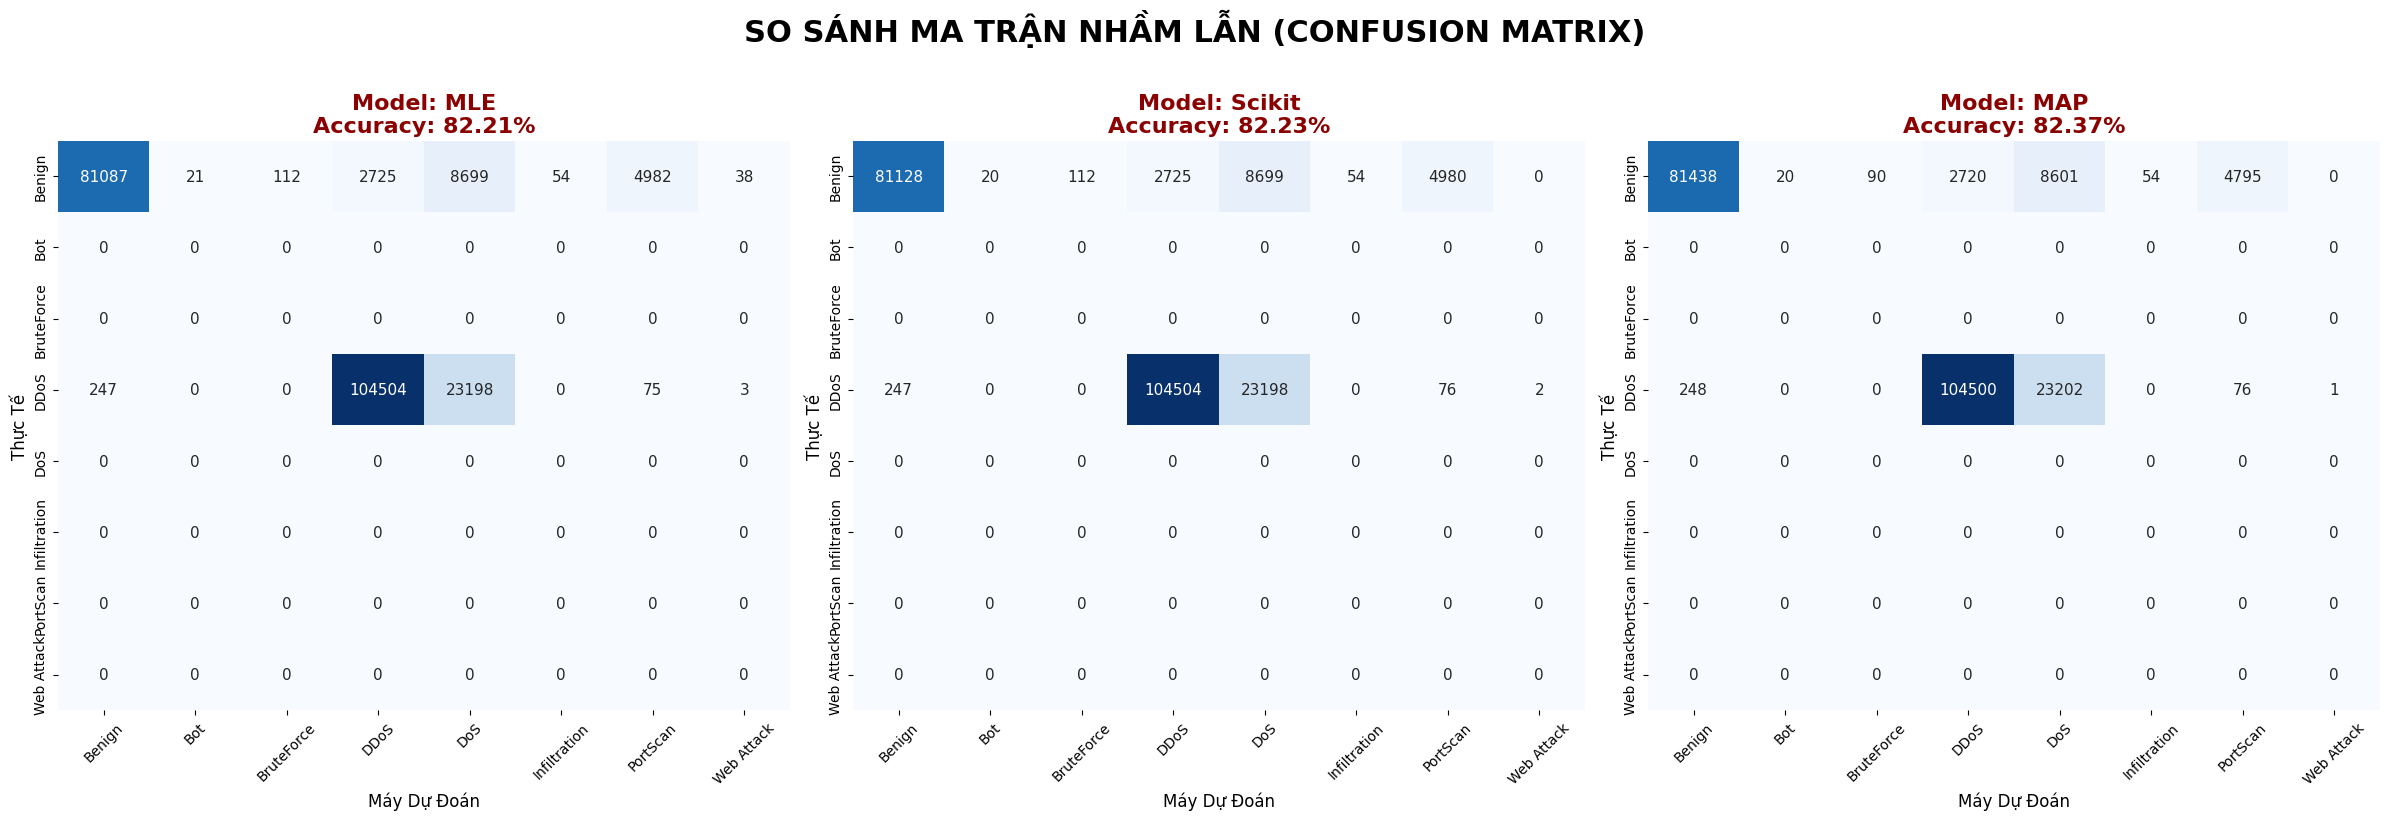

In [21]:
# =============================================================================
# CELL FINAL: VẼ BIỂU ĐỒ TỪ KẾT QUẢ CỦA CELL TRƯỚC (FINAL BATTLE)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

# 1. Kiểm tra an toàn (Xem Cell trước đã chạy chưa)
if 'models' not in locals() or 'X_test_scaled' not in locals() or 'y_test_real' not in locals():
    print("⚠️ LỖI: Bạn chưa chạy Cell 'FINAL BATTLE' để tạo dữ liệu và model!")
else:
    print(">>> ĐANG VẼ BIỂU ĐỒ TỪ DỮ LIỆU TRONG BỘ NHỚ...")

    # 2. Thiết lập khung hình
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('SO SÁNH MA TRẬN NHẦM LẪN (CONFUSION MATRIX)', 
                 fontsize=22, fontweight='bold', y=1.02)
    
    # 3. Lặp qua 3 model đã train ở cell trước
    for i, (name, model) in enumerate(models):
        print(f"   -> Đang vẽ cho model: {name}...")
        
        # Dự đoán lại (hoặc dùng y_pred nếu bạn đã lưu, ở đây predict lại cho chắc)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test_real, y_pred)
        
        # Lấy tập hợp tất cả các nhãn (Thực tế + Dự đoán) để cố định khung ma trận
        # Việc này giúp ma trận vuông vức ngay cả khi model không đoán ra 1 nhãn nào đó
        labels = np.unique(np.concatenate((y_test_real, y_pred)))
        
        # Tính Confusion Matrix
        cm = confusion_matrix(y_test_real, y_pred, labels=labels)
        
        # Vẽ Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=labels, yticklabels=labels, 
                    cbar=False, annot_kws={"size": 11})
        
        # Trang trí
        axes[i].set_title(f"Model: {name}\nAccuracy: {acc:.2%}", 
                          fontsize=16, color='darkred', fontweight='bold')
        axes[i].set_xlabel('Máy Dự Đoán', fontsize=12)
        axes[i].set_ylabel('Thực Tế', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    # 4. Lưu và hiển thị
    plt.tight_layout()
    output_filename = 'confusion_matrix_script3.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
    print(f"\n✅ XONG! Đã lưu ảnh biểu đồ vào file: {output_filename}")
    plt.show()